The fidelity in the adiabatic limit is given by

$$
\mathcal{F}(t_f)\sim 1 - 4a(0)\sin(t_f \Phi / 2),
$$
where $\Phi = \frac{1}{t_f}\int_0^{t_f} dt (E_1(t) - E_0(t))$, and $a(0)$ is the adiabaticity at the beginning of the protocol, which reads

$$
a(0) =\frac{\bra{\psi_m(0)}\partial_t H(0)\ket{\psi_n(0)}}{|E_n(0) - E_m(0)|^2}
$$

In [32]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from brokenaxes import brokenaxes
from scipy.integrate import romb

from HQUAD_lib.QUAD_utils import solve_LZ
from HQUAD_lib.parallel_utils import parameter_run
from HQUAD_lib.hamiltonians import lz_problem
from HQUAD_lib.physics_utils import fidelity_LZ

In [43]:
x = 1

alphas = np.array([2, 3, 4])
betas = alphas
n_plus = (alphas + betas) / 2

tfs = np.linspace(0.1, 120, 500)

In [49]:
def compute_fidelity_total(alpha, beta):
    z_sol = solve_LZ(alpha, beta, x=x)
    s = np.linspace(0, 1, len(z_sol))

    # Fidelities
    fidelitites = parameter_run(fidelity_LZ, 'tf', tfs, pulse=z_sol, x=x, z0=-10,
                                pbar_kwargs=dict(leave=False))

    
    # Resonances
    hypermatrix = np.array([lz_problem(x, z) for z in z_sol])
    eigvalues, eigmodes = np.linalg.eigh(hypermatrix)
    
    gap = eigvalues[:, 1] - eigvalues[:, 0]
    phi = romb(gap, dx=s[1] - s[0])
    phi = 2 * np.pi / phi

    # Adiabaticity
    d_eigmodes = np.gradient(eigmodes, s, axis=0)
    
    temp = np.zeros(len(z_sol))  # Matrix to save the G_tensor
    for k in range(len(z_sol)):
        num = np.abs(eigmodes[k, :, 0].conj() @ d_eigmodes[k, :, 1])
        den = np.abs(eigvalues[k, 0] - eigvalues[k, 1])
    
        temp[k] = num / den
    
    # Compute the c_tilda factor, that include a summation over all the states and an integration
    adiabaticity = temp[1]
    
    return fidelitites, phi, adiabaticity

In [50]:
fidelities = np.zeros((len(alphas), len(tfs)))
periods = np.zeros(len(alphas))
adiabaticities = np.zeros(len(alphas))

pbar = tqdm(total=len(alphas), desc='Computing fidelitites')
for i in range(len(alphas)):
    result = compute_fidelity_total(alphas[i], betas[i])
    
    fidelities[i] = result[0]
    periods[i] = result[1]
    adiabaticities[i] = result[2]
    
    pbar.update()
pbar.close()

Computing fidelitites:   0%|          | 0/3 [00:00<?, ?it/s]

fidelity_LZ: [['tf']]:   0%|          | 0/500 [00:00<?, ?it/s]

fidelity_LZ: [['tf']]:   0%|          | 0/500 [00:00<?, ?it/s]

fidelity_LZ: [['tf']]:   0%|          | 0/500 [00:00<?, ?it/s]

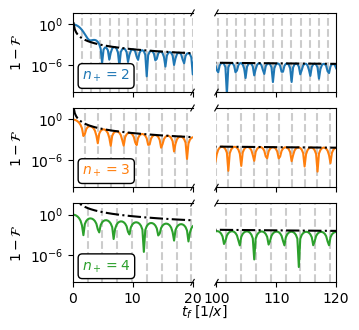

In [51]:
fig = plt.figure(figsize=(3.4, 3.5))

sps = mpl.gridspec.GridSpec(3, 1)

colors = [f'C{i}' for i in range(len(fidelities))]
baxs = [brokenaxes(xlims=((0, 20), (100, 120)), subplot_spec=sps[i],
                   despine=False, tilt=60, d=0.01) for i in range(3)]

for i in range(len(fidelities)):
    baxs[i].plot(tfs, 1 - fidelities[i], c=colors[i])
    baxs[i].set_yscale('log')

    baxs[i].text(0.08, 0.1, rf'$n_+ = {n_plus[i]:.0f}$', ha='left',
                transform=baxs[i].axs[0].transAxes, c=colors[i], va='bottom',
                bbox=dict(boxstyle="round", ec='k', fc='w', alpha=1))

    baxs[i].plot(tfs, 4 * adiabaticities[i] ** 2 / tfs ** 2, c='k' ,ls='-.')

    baxs[i].set_ylim(1e-10, 50)
    
    baxs[i].vlines(np.arange(int(tfs[-1] / periods[i]) + 1) * periods[i],
                   *baxs[i].axs[0].get_ylim(), ls='--', color='k', alpha=0.2, zorder=0)
    
    baxs[i].axs[0].set_ylabel(r'$1 - \mathcal{F}$')
    

for bax in baxs[:2]:
    bax.set_xticklabels([])
baxs[-1].set_xlabel(r'$t_f\; [1 / x]$')

left_axs = [bax.axs[0] for bax in baxs]